In [35]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers,Input,optimizers

In [36]:
apple = pd.read_csv("AAPL.csv")
amazon = pd.read_csv("AMZN.csv")
google = pd.read_csv("GOOG.csv")
google_l = pd.read_csv("GOOGL.csv")
microsoft = pd.read_csv("MSFT.csv")
tesla = pd.read_csv("TSLA.csv")


def paint(data):
    data = data.iloc[::-1]
    data = data.reset_index(drop=True)
    #data['Label'] = np.where(data['adj close'].shift(-1) > data['adj close'], 1, 0)
    #data['Label'] = (data['close'] > data['open']).astype(int)
    return data

tesla = paint(tesla)

tweets = pd.read_csv("D:\johnny的文件夹\FDU 课程\大二下\大数据商务分析\Final project\data\Tweet\Tweet.csv")
company_tweets = pd.read_csv(
    "D:\johnny的文件夹\FDU 课程\大二下\大数据商务分析\Final project\data\Tweet\Company_Tweet.csv")
tweets.drop('writer', axis=1, inplace=True)
df_tweets = pd.merge(tweets, company_tweets, on='tweet_id', how='left')
df_tweets['post_date'] = pd.to_datetime(df_tweets['post_date'], unit='s')
df_tweets['post_date'] = df_tweets['post_date'].dt.strftime('%Y-%m-%d')
df_tweets.drop('tweet_id', axis=1, inplace=True)
df_tweets['tweet_score'] = 1 * df_tweets['comment_num'] + 1 * df_tweets['retweet_num'] + 1.2 * df_tweets['like_num']
df_tweets = df_tweets[df_tweets['tweet_score'] >= 50].reset_index()
df_tweets.drop('index', axis=1, inplace=True)
df_tweets.drop('comment_num', axis=1, inplace=True)
df_tweets.drop('retweet_num', axis=1, inplace=True)
df_tweets.drop('like_num', axis=1, inplace=True)

df_tweets.rename(columns={'post_date': 'date'}, inplace=True)
df_tweets['date'] = pd.to_datetime(df_tweets['date'])

def explore(df, company):
    df1 = df[df['ticker_symbol'] == company]
    score = df1.groupby('date')['tweet_score'].sum()
    df1 = pd.concat([score], axis=1)
    df1 = df1.reset_index()
    return df1


tesla_tweets = explore(df_tweets, 'TSLA')

def make_stock(stock, tweet):
    stock['date'] = pd.to_datetime(stock['date'])
    tweet['date'] = pd.to_datetime(tweet['date'])

    start_date = '2015-01-01'
    end_date = '2019-12-31'
    stock = stock.loc[(stock['date'] >= start_date) & (stock['date'] <= end_date)]
    result = pd.merge(stock, tweet, on='date', how='left')
    return result


tesla = make_stock(tesla, tesla_tweets).dropna()

In [37]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

df=pd.DataFrame(tesla,columns=['date','open','close','tweet_score'])
data = df[['open','close','tweet_score']].values
# 归一化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
print(scaled_data)

# 创建数据集
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :])
        y.append(data[i + time_step, :2])  
    return np.array(X), np.array(y)

time_step = 100
X, y = create_dataset(scaled_data, time_step)

# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


[[2.42688262e-01 2.34204747e-01 1.55234075e-04]
 [2.08418756e-01 2.10881752e-01 1.73145699e-04]
 [1.48660638e-01 1.70640873e-01 1.12246177e-03]
 ...
 [1.00000000e+00 9.98050623e-01 4.32565721e-01]
 [9.78782316e-01 9.43467853e-01 3.66137478e-01]
 [8.97498972e-01 9.56103959e-01 2.27226863e-01]]


In [38]:
# 创建LSTM模型
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 3)))  # 输入形状为(time_step, 2)
model.add(LSTM(units=50))
model.add(Dense(2))  # 输出一个值，即预测的closing价格

model.compile(optimizer='adam', loss='mean_squared_error')

# 训练模型
model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test))

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# 反归一化
train_predict_full = np.concatenate((train_predict, np.zeros((train_predict.shape[0], 1))), axis=1)
test_predict_full = np.concatenate((test_predict, np.zeros((test_predict.shape[0], 1))), axis=1)
train_predict = scaler.inverse_transform(train_predict_full)[:, :2]
test_predict = scaler.inverse_transform(test_predict_full)[:, :2]


Epoch 1/40


C:\Users\johnn\PycharmProjects\Deep Learning\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0735 - val_loss: 0.0112
Epoch 2/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0073 - val_loss: 0.0079
Epoch 3/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0051 - val_loss: 0.0071
Epoch 4/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0050 - val_loss: 0.0069
Epoch 5/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0042 - val_loss: 0.0057
Epoch 6/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0050 - val_loss: 0.0065
Epoch 7/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0041 - val_loss: 0.0059
Epoch 8/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0039 - val_loss: 0.0062
Epoch 9/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0038 - val_loss: 0.0057
Epoch 10/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0038 - val_loss: 0.0047
Epoch 11/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0036 - val_loss: 0.0070
Epoch 12/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0041 - val_l

In [39]:
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, train_predict)
test_mse = mean_squared_error(y_test, test_predict)
print(train_mse, test_mse)
# accuracy, mse
# 相对于原始数据的涨跌

90069.67257623789 73940.7702465127


In [40]:
test_predict

array([[241.02441422, 245.37875951],
       [241.45078959, 246.20182704],
       [245.78042467, 251.10154368],
       [251.75420687, 257.43880756],
       [254.91954813, 260.14460206],
       [254.39718989, 258.81018441],
       [251.77304757, 255.58371652],
       [248.10856748, 251.55715965],
       [242.28447285, 245.38740643],
       [238.2486392 , 241.5471095 ],
       [236.2353366 , 239.93798499],
       [234.90392756, 238.81738613],
       [230.4186823 , 233.90497306],
       [223.8238899 , 226.88938777],
       [217.22122104, 220.16594874],
       [210.830148  , 213.83317527],
       [206.99840006, 210.54403428],
       [205.03698351, 209.07789226],
       [202.91831694, 207.10551979],
       [200.94034064, 205.15188803],
       [199.42602859, 203.65389792],
       [197.89517859, 202.06764923],
       [195.70952726, 199.66075586],
       [195.45555296, 199.52966503],
       [198.19345033, 202.56536974],
       [203.14603639, 207.79421323],
       [207.75100292, 212.27699392],
 

In [41]:
train_predict

array([[195.54665556, 195.87674101],
       [186.77524401, 187.08029982],
       [177.27697419, 177.46603704],
       ...,
       [251.44281207, 253.61409222],
       [246.36957143, 249.43709596],
       [244.17417701, 248.26448713]])

In [42]:
open_predict = np.concatenate([train_predict[:,0], test_predict[:,0]], axis=0)
close_predict = np.concatenate([train_predict[:,1], test_predict[:,1]], axis=0)


In [43]:
open_predict.shape

(843,)

Text(0.5, 1.0, 'Stock Price Prediction')

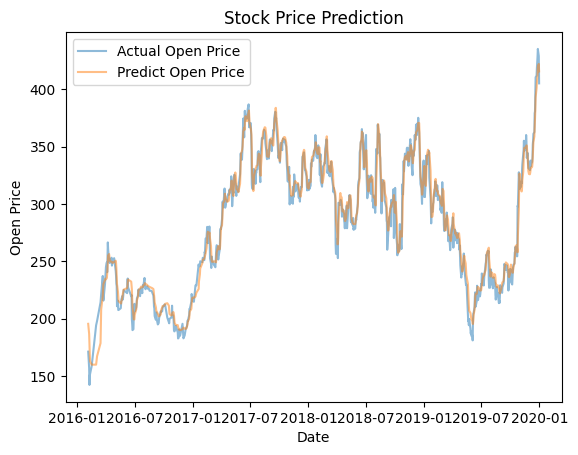

In [44]:
import matplotlib.pyplot as plt
plt.plot(df['date'][time_step:], df['open'][time_step:], label='Actual Open Price', alpha=0.5)
plt.plot(df['date'][time_step:], open_predict, label='Predict Open Price', alpha=0.5)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Stock Price Prediction')

Text(0.5, 1.0, 'Stock Price Prediction')

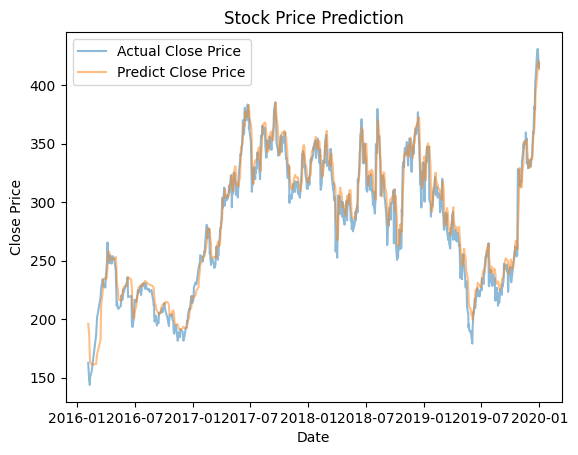

In [45]:
plt.plot(df['date'][time_step:], df['close'][time_step:], label='Actual Close Price', alpha=0.5)
plt.plot(df['date'][time_step:], close_predict, label='Predict Close Price', alpha=0.5)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Price Prediction')

In [46]:
prediction = pd.DataFrame({'pre_open':open_predict, 'pre_close':close_predict})
prediction

,pre_open,pre_close
0,195.546656,195.876741
1,186.775244,187.080300
2,177.276974,177.466037
3,168.873911,169.185927
4,162.879260,163.508374
...,...,...
838,405.479755,404.946468
839,412.359679,411.639943
840,419.190739,418.533101
841,421.921750,420.836968


In [47]:
tesla = tesla[time_step:]
tesla.reset_index(inplace=True)
tesla_stock = pd.concat([tesla, prediction], axis=1)
tesla_stock

,index,date,volume,open,high,low,close,adj close,tweet_score,pre_open,pre_close
0,275,2016-02-05,9437600,171.300003,173.000000,157.740005,162.600006,162.600006,157.2,195.546656,195.876741
1,276,2016-02-08,9313000,157.100006,157.149994,146.000000,147.990005,147.990005,417.6,186.775244,187.080300
2,277,2016-02-09,8651600,142.320007,159.789993,141.050003,148.250000,148.250000,85.4,177.276974,177.466037
3,278,2016-02-10,10406500,150.500000,154.970001,141.740005,143.669998,143.669998,537.6,168.873911,169.185927
4,279,2016-02-11,14252400,152.000000,163.259995,147.000000,150.470001,150.470001,233.6,162.879260,163.508374
...,...,...,...,...,...,...,...,...,...,...,...
838,1253,2019-12-24,8054700,418.359985,425.470001,412.690002,425.250000,425.250000,14706.2,405.479755,404.946468
839,1254,2019-12-26,10633900,427.910004,433.480011,426.350006,430.940002,430.940002,11456.2,412.359679,411.639943
840,1255,2019-12-27,9945700,435.000000,435.309998,426.109985,430.380005,430.380005,14540.0,419.190739,418.533101
841,1256,2019-12-30,12586400,428.790009,429.000000,409.260010,414.700012,414.700012,12314.8,421.921750,420.836968


In [48]:
tesla_stock['pre_Label'] = np.where(tesla_stock['pre_close'].shift(-1) > tesla_stock['pre_close'], 1, 0)
tesla_stock['Label'] = np.where(tesla_stock['close'].shift(-1) > tesla_stock['close'], 1, 0)
tesla_stock.dropna(inplace=True)

In [49]:
tesla_stock

,index,date,volume,open,high,low,close,adj close,tweet_score,pre_open,pre_close,pre_Label,Label
0,275,2016-02-05,9437600,171.300003,173.000000,157.740005,162.600006,162.600006,157.2,195.546656,195.876741,0,0
1,276,2016-02-08,9313000,157.100006,157.149994,146.000000,147.990005,147.990005,417.6,186.775244,187.080300,0,1
2,277,2016-02-09,8651600,142.320007,159.789993,141.050003,148.250000,148.250000,85.4,177.276974,177.466037,0,0
3,278,2016-02-10,10406500,150.500000,154.970001,141.740005,143.669998,143.669998,537.6,168.873911,169.185927,0,1
4,279,2016-02-11,14252400,152.000000,163.259995,147.000000,150.470001,150.470001,233.6,162.879260,163.508374,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
838,1253,2019-12-24,8054700,418.359985,425.470001,412.690002,425.250000,425.250000,14706.2,405.479755,404.946468,1,1
839,1254,2019-12-26,10633900,427.910004,433.480011,426.350006,430.940002,430.940002,11456.2,412.359679,411.639943,1,0
840,1255,2019-12-27,9945700,435.000000,435.309998,426.109985,430.380005,430.380005,14540.0,419.190739,418.533101,1,0
841,1256,2019-12-30,12586400,428.790009,429.000000,409.260010,414.700012,414.700012,12314.8,421.921750,420.836968,0,1


In [50]:
TP = ((tesla_stock['Label'] == 1) & (tesla_stock['pre_Label'] == 1)).sum()
FP = ((tesla_stock['Label'] == 0) & (tesla_stock['pre_Label'] == 1)).sum()
FN = ((tesla_stock['Label'] == 1) & (tesla_stock['pre_Label'] == 0)).sum()

# 计算 Precision 和 Recall
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall)
print(precision, recall, f1)

0.5064102564102564 0.5563380281690141 0.5302013422818792


In [51]:
initial_fund = 10000
funds = initial_fund
for index in range(len(tesla_stock) - 1):
    if tesla_stock.loc[index, 'pre_Label'] == 1:
        # 在下一行的open买入股票
        funds += (tesla_stock.loc[index + 1, 'close'] - tesla_stock.loc[index + 1, 'open'])
print(funds)

10157.18978881836


In [93]:
X = []
y = []
for i in range(len(data)-100-7+1):
    X.append(scaled_data[i:i+100])
    y.append(scaled_data[i+100+7-1, 1])  
X = np.array(X)
y = np.array(y)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(100, 3)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=40, batch_size=32,validation_data=(X_test, y_test))
predictions = []
for i in range(len(X) - split):
    predictions.append(model.predict(np.expand_dims(X[split+i], axis=0))[0, 0])
predictions = scaler.inverse_transform([[0, pred, 0] for pred in predictions])[:, 1]
print(predictions)

Epoch 1/40


C:\Users\johnn\PycharmProjects\Deep Learning\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.1045 - val_loss: 0.0218
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0113 - val_loss: 0.0179
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0097 - val_loss: 0.0173
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0085 - val_loss: 0.0170
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0082 - val_loss: 0.0158
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0088 - val_loss: 0.0150
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0077 - val_loss: 0.0161
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0085 - val_loss: 0.0160
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0081 - val_loss: 0.0170
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0073 - val_loss: 0.0173
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0078 - val_loss: 0.0157
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0076 - val_l

In [94]:
predictions = pd.DataFrame(predictions,columns=['pred'])
predictions

,pred
0,283.933358
1,279.189851
2,271.359991
3,264.034546
4,257.617088
...,...
163,340.241073
164,346.746267
165,350.558414
166,354.137266


In [88]:
tesla_df = tesla[675:]
tesla_df.reset_index(inplace=True)
tesla_df

,level_0,index,date,volume,open,high,low,close,adj close,tweet_score
0,675,1090,2019-05-03,23706800,243.860001,256.609985,243.490005,255.029999,255.029999,16271.8
1,676,1091,2019-05-06,10833900,250.020004,258.350006,248.500000,255.339996,255.339996,5780.8
2,677,1092,2019-05-07,10131400,256.799988,257.209991,245.100006,247.059998,247.059998,7080.6
3,678,1093,2019-05-08,6176400,246.940002,250.600006,244.199997,244.839996,244.839996,7215.8
4,679,1094,2019-05-09,6711400,242.000000,243.679993,236.940002,241.979996,241.979996,4043.8
...,...,...,...,...,...,...,...,...,...,...
163,838,1253,2019-12-24,8054700,418.359985,425.470001,412.690002,425.250000,425.250000,14706.2
164,839,1254,2019-12-26,10633900,427.910004,433.480011,426.350006,430.940002,430.940002,11456.2
165,840,1255,2019-12-27,9945700,435.000000,435.309998,426.109985,430.380005,430.380005,14540.0
166,841,1256,2019-12-30,12586400,428.790009,429.000000,409.260010,414.700012,414.700012,12314.8


In [95]:
tesla_stock1 = pd.concat([tesla_df, predictions], axis=1)
tesla_stock1

,level_0,index,date,volume,open,high,low,close,adj close,tweet_score,pred
0,675,1090,2019-05-03,23706800,243.860001,256.609985,243.490005,255.029999,255.029999,16271.8,283.933358
1,676,1091,2019-05-06,10833900,250.020004,258.350006,248.500000,255.339996,255.339996,5780.8,279.189851
2,677,1092,2019-05-07,10131400,256.799988,257.209991,245.100006,247.059998,247.059998,7080.6,271.359991
3,678,1093,2019-05-08,6176400,246.940002,250.600006,244.199997,244.839996,244.839996,7215.8,264.034546
4,679,1094,2019-05-09,6711400,242.000000,243.679993,236.940002,241.979996,241.979996,4043.8,257.617088
...,...,...,...,...,...,...,...,...,...,...,...
163,838,1253,2019-12-24,8054700,418.359985,425.470001,412.690002,425.250000,425.250000,14706.2,340.241073
164,839,1254,2019-12-26,10633900,427.910004,433.480011,426.350006,430.940002,430.940002,11456.2,346.746267
165,840,1255,2019-12-27,9945700,435.000000,435.309998,426.109985,430.380005,430.380005,14540.0,350.558414
166,841,1256,2019-12-30,12586400,428.790009,429.000000,409.260010,414.700012,414.700012,12314.8,354.137266


In [96]:
tesla_stock1['pre_Label'] = np.where(tesla_stock1['pred'].shift(-1) > tesla_stock1['pred'], 1, 0)
tesla_stock1['Label'] = np.where(tesla_stock1['close'].shift(-1) > tesla_stock1['close'], 1, 0)
TP = ((tesla_stock1['Label'] == 1) & (tesla_stock1['pre_Label'] == 1)).sum()
FP = ((tesla_stock1['Label'] == 0) & (tesla_stock1['pre_Label'] == 1)).sum()
FN = ((tesla_stock1['Label'] == 1) & (tesla_stock1['pre_Label'] == 0)).sum()

# 计算 Precision 和 Recall
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall)
print(precision, recall, f1)

0.5277777777777778 0.6404494382022472 0.5786802030456853
